In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
from pathlib import Path
from typing import *
import torch
import torch.optim as optim
from transformers import *

class Configuracao(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [ ]:
# !gsutil cp gs://dataset-uploader/bbc/bbc-text.csv .

In [ ]:
torch.cuda.is_available()

In [2]:
config = Configuracao(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=6,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=128,
)

from pytorch_pretrained_bert import BertTokenizer

bert_token = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

class FastAiBertTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    def __call__(self, *args, **kwargs):
        return self
    def tokenizer(self, t:str) -> List[str]:
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_token, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

fastai_bert_vocab = Vocab(list(bert_token.vocab.keys()))

df_train=pd.read_csv('train.csv')
df_train.columns

from sklearn.model_selection import train_test_split
train, val = train_test_split(df_train)

databunch = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=['toxic'],
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [3]:
databunch

TextClasDataBunch;

Train: LabelList (119678 items)
x: TextList
[CLS] richard the lion ##heart and sex you seem like a fair guy , so i was wondering if you could help resolve the ti ##ff between silver ##w ##his ##tle and i on richard ' s sexuality . i think the problem is that my edit ##s make the straight theory seem big ##oted and that silver ##w ##his ##tle ' s make the gay theory seem liberal and fantastic ##al . i was thinking we could pour all our arguments into a new section marked ' sexual orientation . ' would you support this and help us ? how can we resolve this without venom ? [SEP],[CLS] " ( ec ) wait a minute , previously it was a " " time zone " " argument , but now it ' s a " " likely to change at any time " " argument ? i ' m hoping that you are co ##gni ##sant of the fact that publications such as the world alma ##nac are printed volumes and are therefore likely to be picked up years after publication ( when information is likely to have changed ) . in such cases , a

In [71]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

modelo = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

learn_data = Learner(
    databunch, modelo,
    metrics=[accuracy]
)

#learn_data.callbacks.append(ShowGraph(learner))



In [72]:
learn_data.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.63E-04


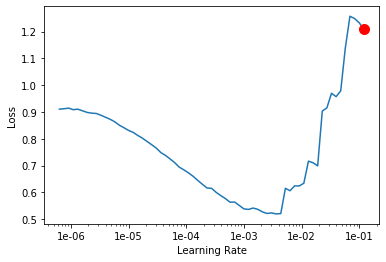

In [73]:
learn_data.recorder.plot(suggestion=True)

In [74]:
learn_data.fit_one_cycle(1, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.086279,0.080389,0.968591,10:55


In [76]:
learn_data.unfreeze()
learn_data.fit_one_cycle(3, max_lr=3e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.066012,0.089585,0.967613,13:20
1,0.047300,0.104047,0.967638,11:58
2,0.022548,0.136898,0.967488,12:29


In [77]:
preds, targets = learn_data.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,35516,717
1,580,3080


In [25]:
data_lm = TextLMDataBunch.from_csv('/home/rubensvectomobile_gmail_com/', 'train.csv', min_freq=1)


In [16]:
data_lm.show_batch()

idx,text
0,""" this hollow arb enforcement request "" "" xxmaj you did ? xxmaj let me see . xxmaj on 17:35 , 23 xxmaj december 2010 that xxup ae was first mentioned on xxup an / xxup i. xxmaj on 18:28 , 23 xxmaj december 2010 you blocked me after on 18:21 , 23 xxmaj december 2010 you made this edit ? xxmaj so when you read the xxup ae report"
1,"otherwise . xxmaj of course , an article can report objectively about such things , as long as an attempt is made to describe the topic from a neutral point of view . "" "" xxmaj even if you view what i did outside xxmaj osteen 's church as self promoting , it is reported in an objective manner . xxmaj further , this account is not the original author"
2,"email . xxmaj thus it is not a copyright violation . 16:21 , 5 xxmaj dec 2003 ( xxup utc ) xxbos "" \n \n xxmaj why xxmaj are xxmaj there xxmaj no xxmaj failure xxmaj examples xxmaj for xxmaj rating xxmaj methods ? \n \n xxmaj the article now reads ( in "" "" xxmaj criticism of xxup iia "" "" ) ... \n \n """
3,"in talk : cult you say that the checklists must go because they are unscientific , though they are clearly mentioned as disputed and attributed to the anti - cult movement . xxmaj the one by xxmaj lifton is referenced . i support replacement of the other checklist by the one by xxmaj eileen xxmaj barker . 12:45 , 3 xxmaj oct 2004 ( xxup utc ) \n xxmaj"
4,"own dubious actions . xxmaj this is n't appreciated , nor is attempting to call my edits "" "" vandalism , "" "" when it was you who was trying to cover your erroneous tracks . xxmaj but that 's all i have to say about it . xxmaj better luck next time . - "" xxbos xxmaj if that 's the case , should we have a section on"


In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [18]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(60000, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(60000, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=60000, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


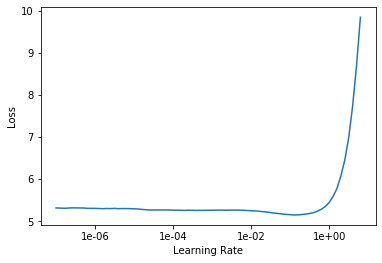

In [19]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.286595,3.882025,0.319007,06:14


In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,3.899805,3.696402,0.342041,07:00
1,3.812038,3.612134,0.354422,07:02
2,3.677744,3.589998,0.357040,07:00


In [22]:
learn.save_encoder('ft_enc_balanced')

In [52]:
data_clas = TextClasDataBunch.from_csv('/home/rubensvectomobile_gmail_com/', 'bbc-text.csv',vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)

data_clas.save('train_ulmfit_balanced_TextClas')

In [53]:
data_clas.show_batch()

text,target
xxbos terror powers expose tyranny the lord chancellor has defended government plans to introduce control orders to keep foreign and british terrorist suspects under house arrest where there isn t enough evidence to put them on trial . lord xxunk insists that the proposals do not equate to a police state and strike a balance between protecting the public against the threat of terrorism and upholding civil liberties . but,politics
xxbos losing yourself in online gaming online role playing games are time - consuming but xxunk flights from reality . but are some people taking their fantasy lives too seriously when video game world of warcraft hit the shops in europe last week fans wrote in to the bbc website to express their delight - and to offer a warning . an addiction to a game like this is far,tech
xxbos xxunk launches veritas party ex - bbc chat show host and east midlands xxunk robert xxunk - silk said he wanted to change the face of british politics as he launched his new party . mr xxunk - silk who recently quit the uk independence party said our country was being stolen from us by mass immigration . he told a london news conference that veritas - latin for,politics
xxbos roundabout continues nostalgia trip the new big - screen version of the magic roundabout released in the uk on friday is the latest attempt to turn children s television into box - office gold . recent years have seen a less - than - successful adaptation of the 1960s puppet show xxunk and a moderately successful version of e xxunk s five children and it previously filmed by the,entertainment
xxbos brits debate over urban music joss stone a 17-year - old soul singer from devon beat xxunk rascal xxunk xxunk and the streets to win best british urban act at the brit awards . her victory has xxunk the debate about what urban music is . i m not really comfortable with the word urban . it s a word that s been manufactured in this country and america,entertainment


In [54]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc_balanced')
learn.freeze()

In [55]:
learn.metrics = [accuracy, FBeta('macro')]

In [56]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.16E-02
Min loss divided by 10: 2.51E-02


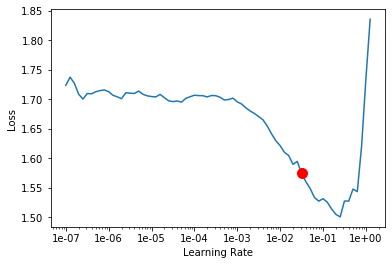

In [57]:
learn.recorder.plot(suggestion=True)

In [58]:
min_grad_lr = learn.recorder.min_grad_lr

In [59]:
learn.fit_one_cycle(cyc_len=1, max_lr=min_grad_lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.227184,1.008177,0.614350,0.552226,00:14


In [60]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.982380,0.666612,0.757848,0.736139,00:20


In [61]:
learn.unfreeze()
learn.fit_one_cycle(8, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.782098,0.539322,0.822870,0.808464,00:25
1,0.693203,0.537543,0.807175,0.806033,00:24
2,0.576277,0.370055,0.887892,0.880457,00:22
3,0.415098,0.271367,0.905830,0.903096,00:24
4,0.328964,0.230496,0.934978,0.928605,00:23
5,0.240137,0.210326,0.928251,0.924620,00:22
6,0.167227,0.207149,0.939462,0.934458,00:23
7,0.165354,0.204513,0.930493,0.927110,00:22


In [66]:
learn.save("trained_ulmfit")

In [67]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)

In [68]:
learn.load('trained_ulmfit')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1779 items)
x: TextList
xxbos rolling out next generation s net the body that oversees how the net works grows and evolves says it has xxunk well with its growth in the last 10 years but it is just the start . in a sense we have hardly started in reaching the whole population the new chair of the internet engineering task force ( xxunk ) brian carpenter says . the xxunk ensures the smooth running and organisation of the net s architecture . with broadband take - up growing services like voice and tv will open up interesting challenges for the net . i think voip ( voice - over internet protocol allowing phone calls to be made over the net ) is very important - it challenges all the old cost models of xxunk says dr carpenter . second it challenges more deeply the business model that you have to be a service provider with a lot of infrastructure . with voip you need very little infrastructure . a distinguished ibm engineer dr carpenter

In [69]:
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4
row_0,,,,,
0,95,2,3,0,5
1,0,63,1,0,1
2,7,5,72,1,0
3,1,2,0,106,0
4,2,1,0,0,79
